In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../src/')
from raytrace3d import OnePointTrace3D
from domain import Boundaries, Stopper, Domain, Slowness

# Tutorial

### This notebook shows how to use the ray tracer with a known analytic solution and can serve as a template for ray tracing in arbitrary media

In [2]:
lf=10 # Maximum length of ray, km
dx = 0.10 # grid spacing in x
dy = 0.10 # grid spacing in y
dz = 0.10 # grid spacing in z

x_coords = np.arange(100)*dx
y_coords = np.arange(120)*dy
z_coords = np.arange(150)*dz

#An analytic solution for constant gradient of slowness squared 
xx, yy, zz = np.meshgrid(x_coords, y_coords, z_coords, indexing='ij')
g_x = 2.2
g_y = 2.1
g_z = 2.5

velocity = np.sqrt(1/(1.5+g_x*xx+g_y*yy+g_z*zz))

slowness = 1.0/velocity

# Numpy gradient returns a list, so cast this to a np array
grad_s = np.asarray(np.gradient(slowness, dx, dy, dz))

slowness = Slowness(slowness, grad_s)
domain = Domain(x_coords, y_coords, z_coords)
bounds = Boundaries(domain)

# Trace many rays at a single takeoff location
takeoff_angles = ([(inclination, 0) for inclination in np.linspace(0, 360, 45)]) #inclination, azimuth
src_coords = [(x_coords[50],y_coords[50],z_coords[30])]*len(takeoff_angles)

tracer = OnePointTrace3D(src_coords=src_coords, 
                         takeoff_angles=takeoff_angles,
                         domain=domain,
                         slowness=slowness,
                         lambda_final=lf)

print("Serial Run")
out = tracer.run(max_step = 0.5, bounds=bounds)

Serial Run
func:'run' took: 0.2221 sec


# Compare to an analytic solution

## 3D Plot

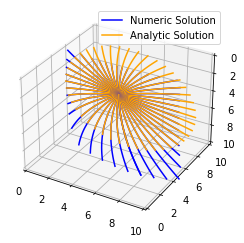

In [10]:
import matplotlib.pyplot as plt

def x_analytic_vsq(sigma, x_0, p_0, g_i):
    '''
    Gives the ith component of the analytic solution
    '''
    return x_0+p_0*sigma+(1/4)*g_i*sigma**2


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
sigma = np.linspace(0, 1, 30)

for i, item in enumerate(out):
    x_0, y_0, z_0, p_1, p_2, p_3, t_0 = item.init_conds  
    x_true = x_analytic_vsq(sigma, x_0=x_0, p_0=p_1, g_i=g_x)
    y_true = x_analytic_vsq(sigma, x_0=y_0, p_0=p_2, g_i=g_y)
    z_true = x_analytic_vsq(sigma, x_0=z_0, p_0=p_3, g_i=g_z)
    out_x = item['y'][0,:]
    out_y = item['y'][1,:]
    out_z = item['y'][2,:]


    if i == 0:
        label1='Numeric Solution'
        label2='Analytic Solution'
    else:
        label1 = ''
        label2 = ''
        
    ax.plot(out_x, out_y, out_z, color='blue', label=label1)
    ax.plot(x_true, y_true, z_true, color='orange', label=label2)
    ax.set_xlim(0,10)
    ax.set_zlim(0,10)
    ax.set_ylim(0,10)
    ax.invert_zaxis()
    plt.legend()